In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-22 13:23:58.261641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 13:23:58.261656: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 100,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/100
 1/66 [..............................] - ETA: 8s - loss: 0.0921

2022-03-22 13:24:01.650599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 13:24:01.651072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 13:24:01.651124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-22 13:24:01.651172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-22 13:24:01.651241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0546
Epoch 2/100
66/66 [==============================] - 0s 764us/step - loss: 0.0375 - val_loss: 0.0393
Epoch 3/100
66/66 [==============================] - 0s 743us/step - loss: 0.0289 - val_loss: 0.0307
Epoch 4/100
66/66 [==============================] - 0s 706us/step - loss: 0.0231 - val_loss: 0.0244
Epoch 5/100
66/66 [==============================] - 0s 653us/step - loss: 0.0189 - val_loss: 0.0198
Epoch 6/100
66/66 [==============================] - 0s 636us/step - loss: 0.0159 - val_loss: 0.0166
Epoch 7/100
66/66 [==============================] - 0s 779us/step - loss: 0.0138 - val_loss: 0.0143
Epoch 8/100
66/66 [==============================] - 0s 775us/step - loss: 0.0123 - val_loss: 0.0126
Epoch 9/100
66/66 [==============================] - 0s 658us/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/100
66/66 [==============================] - 0s 799us/step - loss: 0.0101 - val_loss: 0.0102
Epo

66/66 [==============================] - 0s 661us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 82/100
66/66 [==============================] - 0s 596us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 83/100
66/66 [==============================] - 0s 695us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 84/100
66/66 [==============================] - 0s 598us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 85/100
66/66 [==============================] - 0s 708us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 86/100
66/66 [==============================] - 0s 690us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 87/100
66/66 [==============================] - 0s 609us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 88/100
66/66 [==============================] - 0s 795us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 89/100
66/66 [==============================] - 0s 710us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 90/100
66/66 [==============================] - 0s 796us/step - loss: 0.0050 - val_loss: 

In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


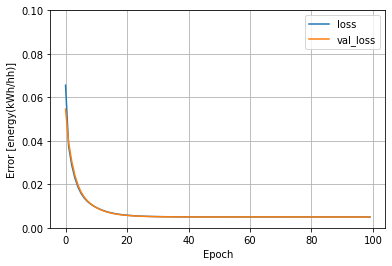

In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [9]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

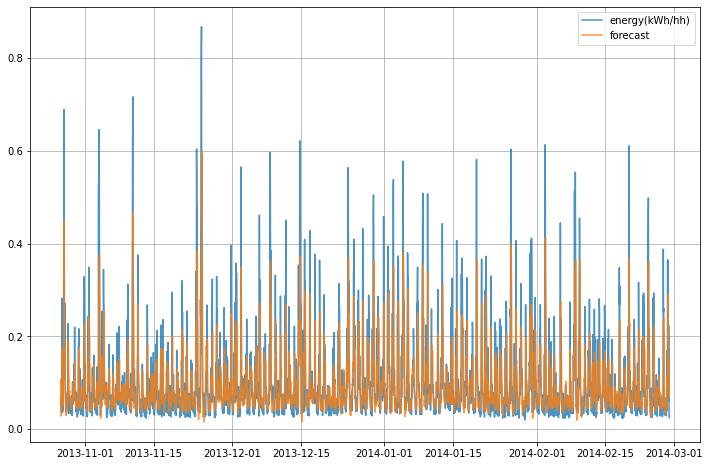

In [10]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_93783/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


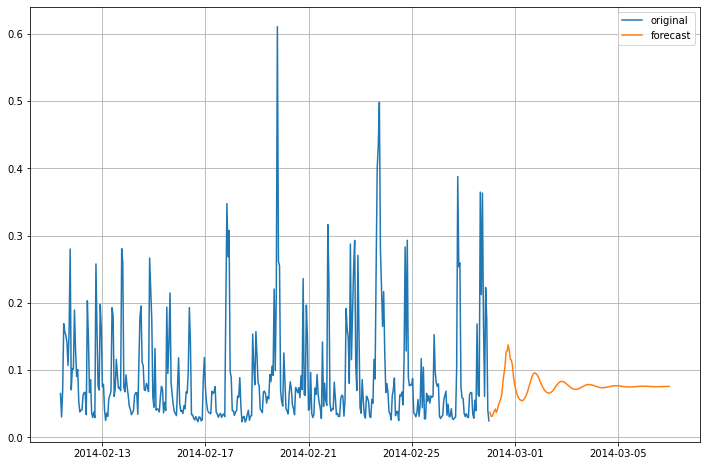

In [11]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [12]:
deep_learner.evaluateMSE()

0.00498770605120235

In [13]:
deep_learner.evaluateRMSE()

0.07062369327075971

In [14]:
deep_learner.evaluateMAE()

0.04109952078562302

In [15]:
deep_learner.evaluateMAPE()

44.42143087181992

In [16]:
yhat =deep_learner.predict()

In [17]:
yhat

[0.1074468,
 0.06542826,
 0.051904187,
 0.040653445,
 0.0279274,
 0.037875418,
 0.04807394,
 0.05679158,
 0.094408296,
 0.17193194,
 0.10005796,
 0.07854442,
 0.06815536,
 0.049817573,
 0.102265246,
 0.12102499,
 0.17903805,
 0.29459816,
 0.45072836,
 0.27845675,
 0.1745923,
 0.16896191,
 0.17433853,
 0.11146663,
 0.07353315,
 0.05829017,
 0.029010408,
 0.03383393,
 0.041048177,
 0.04331231,
 0.03505437,
 0.045219496,
 0.055613592,
 0.06584115,
 0.055437107,
 0.073534116,
 0.0678318,
 0.14549157,
 0.1888011,
 0.16654743,
 0.12014614,
 0.112635195,
 0.0713028,
 0.079475656,
 0.07858628,
 0.08277245,
 0.06910096,
 0.05407165,
 0.053985395,
 0.048388954,
 0.04286705,
 0.041844934,
 0.04182712,
 0.045758978,
 0.065212965,
 0.06860003,
 0.055846304,
 0.057419337,
 0.056225505,
 0.07386361,
 0.097337976,
 0.07748772,
 0.07515794,
 0.063090205,
 0.08483674,
 0.06753211,
 0.07406647,
 0.10594932,
 0.07131748,
 0.08955886,
 0.14613801,
 0.08682443,
 0.08661069,
 0.073385,
 0.065996304,
 0.06280